# Advanced ML - EX1

## Load the data

### Imports

In [64]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784')

# Split the data into training and testing sets
x_train, x_test = mnist.data[:60000], mnist.data[60000:]
y_train, y_test = mnist.target[:60000], mnist.target[60000:]

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Print dataset shapes
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)


/Users/admin/anaconda3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Training data shape: (60000, 784)
Training labels shape: (60000,)
Test data shape: (10000, 784)
Test labels shape: (10000,)



### Data exploration

Describe the data

In [26]:
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 358.9 MB
None


In [25]:
null_vals = x_train.isna().sum()
print(f"There are {len(null_vals[null_vals != 0])} missing values in x_train.")

There are 0 missing values in x_train.


In [27]:
print(x_train.describe())

        pixel1   pixel2   pixel3   pixel4   pixel5   pixel6   pixel7   pixel8  \
count  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel9  pixel10  ...      pixel775      pixel776      pixel777  \
count  60000.0  60000.0  ...  60000.000000  60000.000000  60000.000000   
mean       0.0      0.0  ...      0.000786      0.000348      0.000179   
std        0.0      0.0  ...      0.023696      

Present the label distribution

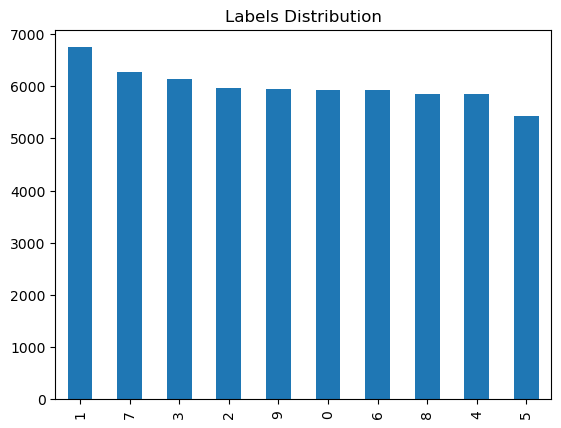

In [21]:
y_train.value_counts(dropna=False).plot(kind='bar')
plt.title("Labels Distribution") 
plt.show()

Present some of the images:

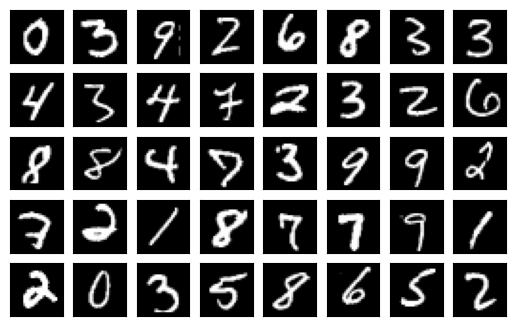

In [62]:
N=40
images= np.random.randint(low=0, high=42001, size=N).tolist()

images = x_train.iloc[images,:]
# images.drop(columns=['label'], inplace=True)
images.index = range(1, N+1)

for i, row in images.iterrows():
    plt.subplot(N//8 + 1, 8, i)
    pixels = row.values.reshape((28,28))
    plt.imshow(pixels, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Part 1 - Clustering

### Imports

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, completeness_score, homogeneity_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

### Cluster

In [71]:
def cluster_data(data, clustering_algorithm, hyperparams):
    """
    Cluster the input data using the specified clustering algorithm and hyperparameters.
    Parameters:
    data (numpy array): input data to be clustered
    clustering_algorithm (sklearn.cluster object): clustering algorithm object from scikit-learn
    hyperparams (dictionary): dictionary of hyperparameters for the clustering algorithm
    Returns:
    numpy array: cluster labels for each data point
    """
    clustering_model = clustering_algorithm(**hyperparams)
    labels = clustering_model.fit_predict(data)
    return labels

### Visualize

In [72]:
def visualize_clusters(data, labels, n_clusters):
    """
    Visualize the clusters by displaying a few images from each cluster.
    Parameters:
    data (numpy array): input data to be clustered
    labels (numpy array): cluster labels for each data point
    n_clusters (int): number of clusters
    Returns:
    None
    """
    fig, ax = plt.subplots(n_clusters, 5, figsize=(12, 12))
    for i in range(n_clusters):
        indices = np.where(labels == i)[0]
        for j in range(5):
            ax[i, j].imshow(data[indices[j]].reshape(8, 8), cmap='gray')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
        ax[i, 0].set_ylabel(f'Cluster {i}', rotation=0, labelpad=20)
    plt.tight_layout()
    plt.show()


### Evaluation metrics

In [83]:
def evaluate_clustering(labels, true_labels, data):
    """
    Evaluate the clustering result using three metrics: Silhouette score, completeness score,
    and homogeneity score.
    Parameters:
    labels (numpy array): cluster labels for each data point
    true_labels (numpy array): true labels for each data point
    data (numpy array): input data to be clustered
    Returns:
    tuple: four clustering metrics: Silhouette score, completeness score, and homogeneity score.
    """
    silhouette_avg = silhouette_score(data, labels)
    completeness_avg = completeness_score(true_labels, labels)
    homogeneity_avg = homogeneity_score(true_labels, labels)
    return silhouette_avg, completeness_avg, homogeneity_avg

In [84]:
def run_pipeline(data, true_labels, clustering_algorithm, hyperparams, ):
    """
    Run the clustering pipeline on the input data using the specified clustering algorithm and hyperparameters,
    and return four clustering metrics: adjusted Rand score, Silhouette score, completeness score, and homogeneity score.
    Parameters:
    data (numpy array): input data to be clustered
    clustering_algorithm (sklearn.cluster object): clustering algorithm object from scikit-learn
    hyperparams (dictionary): dictionary of hyperparameters for the clustering algorithm
    Returns:
    tuple: four clustering metrics: adjusted Rand score, Silhouette score, completeness score, and homogeneity score.
    """
    # Cluster the data
    labels = cluster_data(data, clustering_algorithm, hyperparams)
    # Evaluate the clustering
    silhouette_avg, completeness_avg, homogeneity_avg = evaluate_clustering(labels, true_labels, data)
    visualize_clusters(data, labels, hyperparams['n_clusters'])
    return silhouette_avg, completeness_avg, homogeneity_avg


### K Means

/Users/admin/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyError: 2

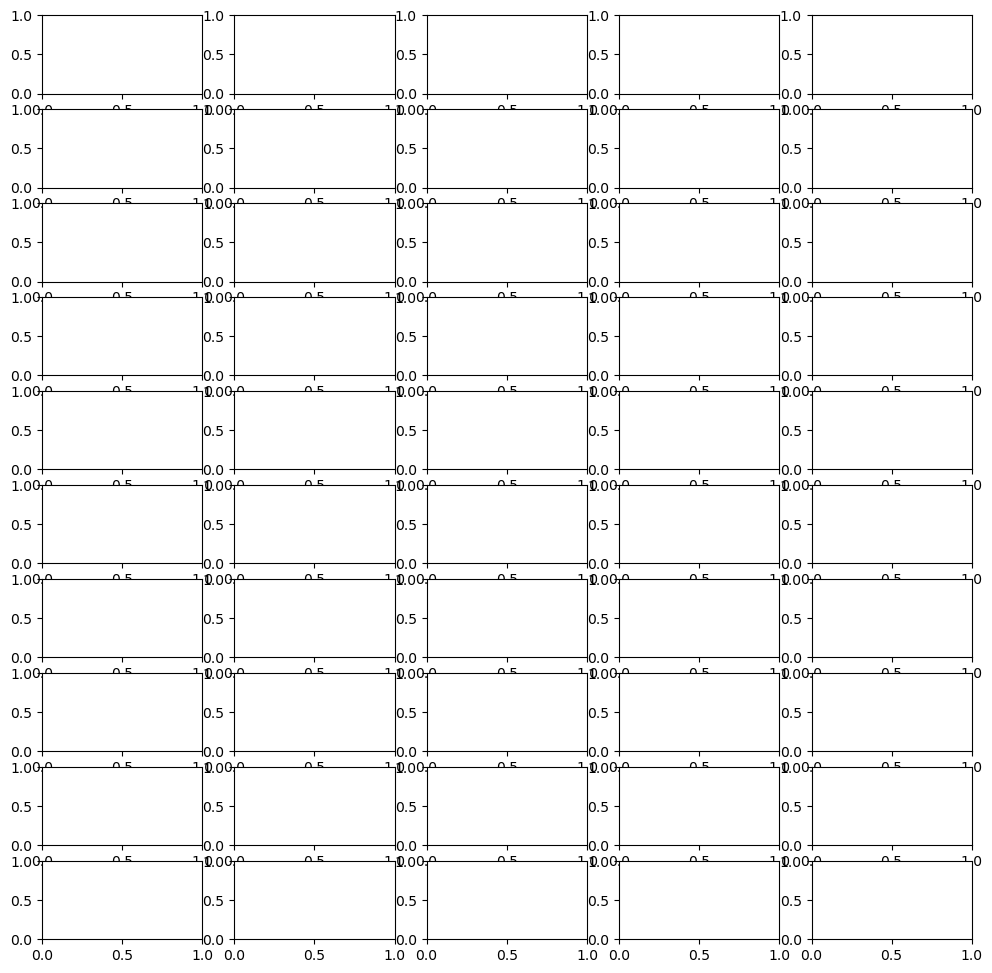

In [85]:
n_clusters = len(set(y_train))
k_means = run_pipeline(x_train, y_train, KMeans, hyperparams={'n_clusters': n_clusters})  



In [ ]:
k_means